# W207 Final Project

## Team Pacific Knights
Members: Alan Wang, Daniel Sheinin, Kuan Lin, Michael Andrew Kennedy, Saru Mehta

## Competition Description:
“What’s Cooking” - https://www.kaggle.com/c/whats-cooking
The goal of this competition is to successfully classify a set of recipes into one of twenty geographic regions of origin according to the ingredients they use. The competition provides a labeled training data set containing lists of raw ingredients and the cuisine they belong to. A second unlabeled data set is provided for scoring purposes.  Competitors are ranked by their ability to accurately label the test set. Competitors are granted up to 5 scoring attempts per day.

An example of a recipe node in train.json:
``` json
 {
 "id": 24717,
 "cuisine": "indian",
 "ingredients": [
     "tumeric",
     "vegetable stock",
     "tomatoes",
     "garam masala",
     "naan",
     "red lentils",
     "red chili peppers",
     "onions",
     "spinach",
     "sweet potatoes"
 ]
 }
```

## Performance:
As of a few days before the end of the competition, almost none out of over 1200 teams have scored higher than 0.82. Our initial submission scored over 0.79, which was towards the top of the leaderboard. Because this is a friendly competition, there is some discussion of technique and open source code publicly available. From this it appears that the extra couple of points tends to come from using 3rd-party algorithms like XGBoost and complex combinations of algorithms that take a lot of time and processing power to run. Because of the nature of the assignment, we chose instead to focus on the features and aspects more relevant to the course. These may have been worthwhile explorations, but they did not ultimately contribute much to our high score (0.79445), which was accomplished with relatively simple parameters.

In [1]:
import numpy as np
import csv
import re
import json
import os
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectPercentile, chi2
import string #use the punctuation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

# Load data

In [2]:
with open('train.json') as data_file:    
    all_train_data = json.load(data_file)
    all_train_labels = np.array([d["cuisine"] for d in all_train_data])
with open('test.json') as data_file:
    all_test_data = json.load(data_file)

# Initial Exploration:
We start by treating the ingredients as bag of words and use text-classification models.
Using basic text preprocessor on TD-IDF vectorizer, perform grid search and compare simple models:

In [5]:
dev_test_data = ['\n'.join(d["ingredients"]) for d in all_train_data[:len(all_train_data)/3]]
dev_test_label = [d["cuisine"] for d in all_train_data[:len(all_train_data)/3]]
dev_train_data = ['\n'.join(d["ingredients"]) for d in all_train_data[len(all_train_data)/3:]]
dev_train_label = [d["cuisine"] for d in all_train_data[len(all_train_data)/3:]]

def text_preprocessor(s):
    return s.lower().replace("-", " ").replace("_", " ")

print "vectorizing texts..."
vec = TfidfVectorizer(preprocessor=text_preprocessor, ngram_range=(1,2), max_df=0.5, strip_accents='unicode')
dev_train_vec = vec.fit_transform(dev_train_data)
dev_test_vec = vec.transform(dev_test_data)

print "grid search on logistic regression:"
params = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0], 'penalty': ['l1', 'l2']}
model_logistic = GridSearchCV(LogisticRegression(), param_grid=params, scoring='accuracy')
model_logistic.fit(dev_train_vec, dev_train_label)
print "best parameters:"
print str(model_logistic.best_params_)
print "accuracy: %.4f" % model_logistic.score(dev_test_vec, dev_test_label)
print
print "grid search on MultinomialNB:"
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0]}
model_MNB = GridSearchCV(MultinomialNB(), param_grid=alphas)
model_MNB.fit(dev_train_vec, dev_train_label)
print "best parameters:"
print str(model_MNB.best_params_)
print "accuracy: %.4f" % model_MNB.score(dev_test_vec, dev_test_label)

vectorizing texts...
grid search on logistic regression:
best parameters:
{'penalty': 'l2', 'C': 11.0}
accuracy: 0.7859

C:\Anaconda\lib\site-packages\sklearn\grid_search.py:370: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:607: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)




grid search on MultinomialNB:
best parameters:
{'alpha': 0.01}
accuracy: 0.7385


Now we take a look at the confusion matrix to see which cousines the basic model is having trouble to classify:

In [6]:
from sklearn.metrics import confusion_matrix
import sys

print "make a confusion matrix on the best initial model"
cm = confusion_matrix(dev_test_label, model_logistic.predict(dev_test_vec))
for row in cm:
    for col in row: sys.stdout.write("%4d "%col)
    sys.stdout.write("\n")
print
print "classes:"
print str(model_logistic.best_estimator_.classes_)

make a confusion matrix on the best initial model
  84    0    2    0    3    6    0    4    0   13    0    0    0   23    0    2   16    5    6    0 
   0  105    3    1    1   44    3    7   19   21    5    1    0    6    0    4   56    1    1    0 
   1    2  379    0    1   29    0    2    1   27    1    0    0   18    1    4   73    2    0    0 
   1    3    3  769    6    2    0    7    0   14    0   15   16    4    0    2   17    1   23   12 
   2    3    1   31  153    6    0    2    0   10    1    2    1   11    1    0   14    2    3    6 
   0    4    6    1    3  565    6    7    8  166    0    2    0    8    2    8   65   16    0    1 
   0    0    0    2    0    9  272    9    1   65    0    1    0    3   12    1    4    8    0    0 
   2    0    0    2    3    4    9  882    0    6    1    0    1   21   15    0   11    0    8    0 
   1   12    0    1    0   31    3    1   97   15    3    0    0    4    2    1   34    3    0    0 
   1    6    4    0    0  115   39    3  

Looks like Italian and French cuisines are confusing.  Next we will try to preprocess the ingredient list to see if can reduce the confusion.

# Ingredient List preprocessing

The preprocessing function works on a list of ingredients as extracted from the json BEFORE it is submitted to the vectorizer, so we can take into account the boundaries between ingredients, which are lost once we extract the text to send to the vectorizer.

To refine the basic model we use:
- Custom stop words. The basic idea is to use a list of words that are commonly used in ingredients but have no significance to labelling. Results are mixed. We are able to increase the score by adding certain words, but others decrease the score. The result changes if we re-slice the data. This tells us that we're probably overfitting. With more work we might be able to come up with a generally useful list.
- Stemming: NLTK snowball. Marginal benefit, if any.
- n-grams: Some success with 2-grams. We create them here by joining words together, rather than delegating the task to the vectorizer, so we can restrict n-grams to within ingredients, rather than spanning ingredients, which assigns meaning to the ingredient order. There is also some apparent improvement from extracting n-grams from the end of the ingredient and not the beginning, since ingredients with more than two words tend to start with less useful adjectives and end with more useful adjective/noun pairs.

In [3]:
stop_words = ['chopped', 'ground', 'dark', 'large', 'Italian', 'grated', 'sliced', 'salt', 'kosher',
 'fresh', 'whole', 'minced', 'shredded']

# A baseline ingredient processing function that does nothing (for comparison)
def proc_ingredients_base(strings):
    return strings

# The ingredient processing function
def proc_ingredients(strings):
    # An empty list for the processed ingredients
    new_strings = []
    
    # 2-grams are useful, but any more than 2 degrades performance
    ngram_max = 2
    
    # Loop through ingredients
    for s in strings:
        # split ingredient into words and add words to list
        # (here's a better place to use the stemmer)
        tokens = [stemmer.stem(t) for t in s.split() if t not in stop_words]
        
        # Add each individual token to the list
        new_strings.extend(tokens)
        
        # simulate n-grams (by concatenating words without spaces) within each ingredient
        n_original_tokens = len(tokens)
        if n_original_tokens > 1:
            for n in xrange(2, min(ngram_max + 1, n_original_tokens + 1)):
                # This takes all valid n-grams within the ingredient...
                #for i in xrange(n_original_tokens - n + 1):
                # This just takes the n-gram at the end of the ingredient...
                for i in xrange(max(0, n_original_tokens - n), n_original_tokens - n + 1):
                    new_strings.append("".join(tokens[i: i + n]))
                    
    return new_strings

# Classification Pipeline

Combine bag-of-words with other numerical features extracted from the ingredient lists and pipe into a single classifier. Ingredient count is likely to be the most significant numerical feature, since cuisines could reasonably tend to differ by number of ingredients and this would not be significantly accounted for by tfidf weighting.

Note the use of the proc_ingredients function in FeatureExtractor.transform(), which preceeds the TFidfVectorizer in the pipeline.

In [4]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract all of the features we want from the recipe data"""
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, recipes):
        features = np.recarray(shape=(len(recipes),),
                               dtype=[('ingredient_text', object),
                                      ('ingredient_count', np.int32, (1,)),
                                      ('character_count', np.int32, (1,)),
                                      ('avg_word_length', np.float64, (1,)),
                                      ('avg_ing_length', np.float64, (1,)),
                                     ])
        for i, recipe in enumerate(recipes):
            ingredients = recipe['ingredients']
            features['ingredient_count'][i] = len(ingredients)
            words = ' '.join(ingredients)
            char_count = len(''.join(words.split()))
            features['character_count'][i] = char_count
            features['avg_word_length'] = float(char_count) / len(words.split())
            features['avg_ing_length'] = float(len(words.split())) / len(ingredients)
            features['ingredient_text'][i] = ' '.join(proc_ingredients(ingredients)) # <- proc_ingredients
        return features
    
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key."""
    
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]    

pipeline = Pipeline([
    ('extract', FeatureExtractor()),
    
    ('union', FeatureUnion(
        transformer_list=[
            
            ('text', Pipeline([
                ('select', ItemSelector(key='ingredient_text')),
                ('tfidf', TfidfVectorizer(max_df=0.5)),
            ])),         

            ('ingredient_count', Pipeline([
                ('select', ItemSelector(key='ingredient_count')),
            ])),
                    
            ('character_count', Pipeline([
                ('select', ItemSelector(key='character_count')),
            ])),                    

            ('avg_word_length', Pipeline([
                ('select', ItemSelector(key='avg_word_length')),
            ])),
                    
            ('avg_ing_length', Pipeline([
                ('select', ItemSelector(key='avg_ing_length')),
            ])),
        ],
                
        # playing with the weights doesn't seem to help when regression is the classifier
        transformer_weights={
            'text': 1.0,
            'ingredient_count': 1.0,
            'character_count': 1.0,
            'avg_word_length': 1.0,
            'avg_ing_length': 1.0,
        },
    )),

    # Try various models and parameters
    #('regression', GridSearchCV(LogisticRegression(), {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})),
    ('regression', LogisticRegression(C=10.0)),
    #('svc', SVC(kernel='linear')),
    #('svc', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
])

# For testing: generate pipeline score

In [5]:
train_data, dev_data, train_labels, dev_labels = train_test_split(all_train_data, 
                                                                  all_train_labels, 
                                                                  test_size=0.33, 
                                                                  random_state=12)

pipeline.fit(train_data, train_labels)
print pipeline.score(dev_data, dev_labels)

0.7928538778


# For live run: predict and export

In [10]:
pipeline.fit(all_train_data, all_train_labels)
pred = pipeline.predict(all_test_data)
ids = np.array([d["id"] for d in all_test_data])
results = np.vstack((ids, pred)).T
np.savetxt("submission.csv", results, delimiter=",", fmt="%s", header="id,cuisine", comments="")

# Analyze results

Calculate R value for each prediction and have a look at the mistakes. A couple of potential insights:
- The worst mistakes are pretty hopeless. Some of theme are non-descript, but a lot of them use the "wrong" ingredients for the label, e.g. Parmesan cheese in Chinese food. These are not necessarily authentic recipes--they are (probably Western) people's contributed interpretations of some type of cuisine, so they're bound to be weird and overlap.
- Some of the near misses have ingredients with more than 2 words in which all but the last couple of words are toss-aways, e.g. "ground black pepper", "hot pepper sauce", "light corn syrop", "grated lemon zest". Including some of these words in a stop word list is one way to go, but the general structure of the ingredients seems to be more important words towards the end. Hence the modification to n-gram construction above in which we just take the 2-gram from the end.

In [8]:
def print_r(R, indexes, pred, data, labels):
    for i in indexes:
        print R[i]
        print "Predicted: %s" % pred[i]
        print "Actual: %s" % labels[i]
        print '\n',
        print data[i]['ingredients']
        print '_' * 30, '\n'         # print separator       
        
# for testing: worst R values
predicted = pipeline.predict(dev_data)
probs = pipeline.predict_proba(dev_data)

# calculate R for each prediction
R = np.empty(probs.shape[0])
for i in range(probs.shape[0]):
    R[i] = max(probs[i]) / probs[i,np.where(pipeline.classes_ == dev_labels[i])]

# Find top 30 R values, i.e. the worst 30 predictions
worst_predictions = np.argpartition(R, -30)[-30:]
print "Worst predictions"
print "###############################\n"
print_r(R, worst_predictions, predicted, dev_data, dev_labels)

# Find 30 with the lowest R values that were not matched correctly
R[R == 1] = np.inf
nearest_misses = np.argpartition(R, 30)[:30]
print "Nearest misses"
print "###############################\n"
print_r(R, nearest_misses, predicted, dev_data, dev_labels)

Worst predictions
###############################

787.678477832
Predicted: southern_us
Actual: spanish

[u'sugar', u'unsalted butter', u'milk', u'all-purpose flour', u'warm water', u'salt', u'active dry yeast', u'white cornmeal']
______________________________ 

814.122192883
Predicted: southern_us
Actual: mexican

[u'eggs', u'milk', u'sugar', u'butter']
______________________________ 

831.987275809
Predicted: chinese
Actual: filipino

[u'large egg whites', u'sesame oil', u'peanut oil', u'soy sauce', u'peeled fresh ginger', u'ground pork', u'corn starch', u'minced garlic', u'jicama', u'salt', u'white sesame seeds', u'sugar', u'black sesame seeds', u'wonton wrappers', u'scallions']
______________________________ 

872.746364179
Predicted: spanish
Actual: korean

[u'vegetable oil', u'salt', u'green bell pepper', u'red bell pepper', u'large eggs']
______________________________ 

893.346603071
Predicted: mexican
Actual: filipino

[u'onion powder', u'ground cumin', u'ground black pepper'

# Further Error Analysis
Mistakes are not evenly distribued across predicted/actual cuisine pairs (one cuisine being mistaken for another). The top ~30 mistakes comprise ~50% of the model error, meaning that our model has problems in a relatively small number of cases. 

These major errors are probably hopeless, due to the lack of discriminatory power of ingredients are similar/identical. In order to make improvements in this set of data, more information is needed. For example, recipe amounts or cuilinary techniques used could help to further separate these groups. 

In the plot below, the diagonal line represents a model where errors are randomly distributed between (predicted cuisine/actual cuisine) pairs. A curve farther in the top left corner represents a model with a greater percentage of error due to fewer confused pairs. 

Out of 380 possible predicted cuisine / actual cuisine pairs,
FRENCH recipes are mistaken for ITALIAN comprising 4.16% errors in the dev set
ITALIAN recipes are mistaken for SOUTHERN_US comprising 2.83% errors in the dev set
SOUTHERN_US recipes are mistaken for CAJUN_CREOLE comprising 2.46% errors in the dev set
ITALIAN recipes are mistaken for SPANISH comprising 2.35% errors in the dev set
ITALIAN recipes are mistaken for GREEK comprising 2.21% errors in the dev set
THAI recipes are mistaken for VIETNAMESE comprising 2.02% errors in the dev set
CHINESE recipes are mistaken for JAPANESE comprising 1.99% errors in the dev set
CAJUN_CREOLE recipes are mistaken for SOUTHERN_US comprising 1.91% errors in the dev set
SOUTHERN_US recipes are mistaken for FRENCH comprising 1.80% errors in the dev set
FRENCH recipes are mistaken for SOUTHERN_US comprising 1.66% errors in the dev set


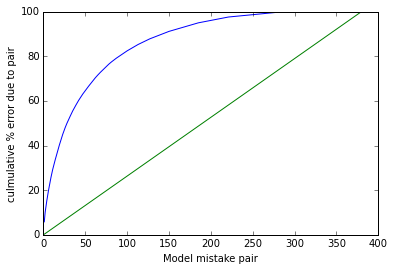

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

#The top n_mistakes are shown
n_mistakes = 10
# Set up mistake printing 
n_mistakes_printed = 0
print "Out of 380 possible predicted cuisine / actual cuisine pairs,"

unique_labels = np.unique(all_train_labels).tolist()
cm = confusion_matrix(dev_labels,predicted, labels = unique_labels)

# Create a copy of the confusion matrix with the x=y diagonal removed
# This makes it a lot easier to sort confused pairs by rank
cm_nodiag = np.copy(cm)
np.fill_diagonal(cm_nodiag,0)

# Figure out how many percentage points each mistake is worth
cm_size = sum(sum(x) for x in cm_nodiag)/100.0
culmulative = 0
individual = []


# Gather errors by rank until we run out of errors. 
ix = np.argmax(cm_nodiag.ravel())
i = ix/20
j = ix%20
while cm_nodiag[i,j]>0:
    culmulative += cm_nodiag[i,j]
    cm_nodiag[i,j]=0
    individual.append(culmulative/cm_size)
    ix = np.argmax(cm_nodiag.ravel())
    i = ix/20
    j = ix%20
    if n_mistakes_printed<n_mistakes:
        print "%s recipes are mistaken for %s comprising %.2f%% errors in the dev set" \
            % (unique_labels[j].upper(),unique_labels[i].upper(), cm[i,j]/cm_size )
        n_mistakes_printed+=1
# Once we run out of mistakes, fill the remaining pairs with 100%
while len(individual)<380:
    individual.append(100)
    
# Plot culmulative error distribution
plt.plot(range(1,len(individual)+1), individual)
# Plot the line representing randomly distributed error
plt.plot(range(1,len(individual)+1),[x/3.8 for x in range(1,len(individual)+1)])
plt.xlabel("Model mistake pair")
plt.ylabel("culmulative % error due to pair")
plt.show()


# One Vs Rest, Linear SVM with customized preprocessing and tokenization


Step 1) Preprocessing while extracting train and test data from their respective json files.
<br>This will reduce the time spent and load in the tokenization process of the tf-idf vectorization

In [2]:
# List of stop words and adjectives that cause overfitting 
cachedStopWords = stopwords.words("english") # from nltk
adj_words = ['refrigerated','fresh','freshly']

# Open the Training Data file and divide into training and dev set
train_file = os.path.join(".","train.json")

with open(train_file) as data_file:
    train_data = json.loads(data_file.read())

random.shuffle(train_data)

n = 3 #number of partitions, want all the training data so chose very high n... lazy approach I know
dev_test_label = [d["cuisine"] for d in train_data[:len(train_data)/n]]
dev_train_label = [d["cuisine"] for d in train_data[len(train_data)/n:]]

# Preliminary Text Pre-Processing , rest is done in tokenize() of TF-IDF
# data should be a list of strings
# for tokenizer to token phrases instead of words, each line in an ingredient should be followed by a comma
dev_test_data = []
for doc in train_data[:len(train_data)/n]:
    # collect all the words for that recipe
    ingredient_phrase_list = []
    for ingredient_phrase in doc["ingredients"]: #this is a line/row
        #lower case
        ingr_phrase = ingredient_phrase.lower()
        # strip digits from the word phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if not word.isdigit()])
        # remove stop words from the phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if word not in cachedStopWords])
        # remove other words from the phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if word not in adj_words])
        # Append the ingredient phrase to join by ,
        ingredient_phrase_list.append(ingr_phrase)
     
    #join each list item with ,
    dev_test_data.append(','.join(ingredient_phrase_list))
    
dev_train_data = []
for doc in train_data[len(train_data)/n:]:
    # collect all the words for that recipe
    ingredient_phrase_list = []
    for ingredient_phrase in doc["ingredients"]:
        #lower case
        ingr_phrase = ingredient_phrase.lower()
        # strip digits from the word phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if not word.isdigit()])
        # remove stop words from the phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if word not in cachedStopWords])
        # remove other words from the phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if word not in adj_words])
        # Append the ingredient phrase to join by ,
        ingredient_phrase_list.append(ingr_phrase)
     
    #join each list item with ,
    dev_train_data.append(','.join(ingredient_phrase_list))

    
print "Train data shape: ",np.shape(dev_train_data)
print "Dev_test data shape: ",np.shape(dev_test_data)

Train data shape:  (26516,)
Dev_test data shape:  (13258,)


Using all the Train Data and will do Cross validation on random samples of this training data.. you will see below

In [19]:
# Prepare Test Data in same way as Train data, except no partitioning
# Open the Test Data file and divide into training and dev set
test_file = os.path.join(".","test.json")

with open(test_file) as data_file:
    testdata = json.loads(data_file.read())

test_data = []
test_ids = []
for doc in testdata:
    # collect the id for each test_data
    test_ids.append(doc["id"])
    # collect all the words for that recipe
    ingredient_phrase_list = []
    for ingredient_phrase in doc["ingredients"]: #this is a line/row
        #lower case
        ingr_phrase = ingredient_phrase.lower()
        # strip digits from the word phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if not word.isdigit()])
        # remove stop words from the phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if word not in cachedStopWords])
        # remove other words from the phrase
        ingr_phrase = ' '.join([word for word in ingr_phrase.split() if word not in adj_words])
        # Append the ingredient phrase to join by ,
        ingredient_phrase_list.append(ingr_phrase)
     
    #join each list item with ,
    test_data.append(','.join(ingredient_phrase_list))

print "Test data shape: ",np.shape(test_data)

Test data shape:  (9944,)


In [5]:
#units = ['and','or','warm','large','ground','whole', 'mince', 'shred','grate', 'slice','kosher']
units = ['oz','and','or'] # after stemming remove these stop words
#Change compound words after stemming to a simple word for standardization, this seems to reduce my score :(
replacements = {
                #'all purpos flour': 'flour',
                #'extra virgin':'',
                #'oliv oil': 'oliveoil',
                }
#The TFIDF vector tokenizes each string by comma
def tokenize(text):
    #print "text: ", text
    final_tokens = []
    tokens = [ingredient for ingredient in text.split(',')]
    # dont include empty tokens
    for phrase in tokens:  
        cleaned_phrase = phrase 
        if "hidden valley" in cleaned_phrase:
               cleaned_phrase= "hiddenvalley"

        # Replace unicode chars with letter c
        cleaned_phrase = re.sub(r'[^\x00-\x7F]+','c', cleaned_phrase)
        # Remove anything that is not alphabet
        cleaned_phrase = re.sub('[^a-z]+', ' ', cleaned_phrase) 
        # Stem each word
        cleaned_phrase = (" ").join([stemmer.stem(word) for word in cleaned_phrase.split()])
        #cleaned_phrase = (" ").join([WordNetLemmatizer().lemmatize(word) for word in cleaned_phrase.split()])
        # Remove any units from words in the phrase
        cleaned_phrase = (" ").join([word for word in cleaned_phrase.split() if word not in units])
        # remove any unneccary white space that is in front of the phrase
        cleaned_phrase = " ".join(cleaned_phrase.split())
        #print cleaned_phrase
        
        for key, value in replacements.items(): 
            cleaned_phrase = cleaned_phrase.replace(key,value)
           
        # flatten phrase
        for word in cleaned_phrase.split():
            #Replace words with correct spelling if spelt with alternative way
            word= word.replace("yoghurt","yogurt")     
            
            if len(word) >1: #dont count single letter words
                final_tokens.append(word)
    
    return final_tokens

tokenize('grates sliced cheese, baking-powder milk,   extra-  virgin olive    oil,')

[u'grate',
 u'slice',
 u'chees',
 u'bake',
 u'powder',
 u'milk',
 u'extra',
 u'virgin',
 u'oliv',
 u'oil']

Step 2) Fit and transform the train data to tf-idf vector and select 95% of the most correlated features with their class.
Chi2 weeds out the features that are the most likely to be independent of class.
<br> Lastly fit a OnevsRest classifier which fits one classifier per class. For each classifier(20 total), the class is fitted against all the other classes. 

In [7]:
# Fit and transform all the train data- these are tested params from grid search
vec = TfidfVectorizer(tokenizer=tokenize, max_df=.50, min_df=1, lowercase=False,ngram_range=(1,2), binary=True,
                     sublinear_tf=True)

train = vec.fit_transform(dev_train_data)
size =len(vec.get_feature_names())
print "Number of features: ", size

# Feature Selection using chi square- find and keep p% best correlation between words(features)
ch2 = SelectPercentile(chi2, percentile=95) #use 95% of those features
X_train_features = ch2.fit_transform(train, dev_train_label)

# Fit into One vs Rest model( creates a model for each class and compares the confidence score
# among the models for each data. Classifier choses is LinearSVM model
svm= OneVsRestClassifier(LinearSVC(C=.50,)) # C is the regularization param, the large C, the smaller margin of error of the decision boundary line

Number of features:  60639


Step 3) Calculate Accuracy on random samples of the all the training data using Cross Validation (k_folds=3)

In [12]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(svm, X_train_features, dev_train_label) # this creates 3 folds and fits the X_train after chi
print "Mean Score: ", np.mean(scores)
print "All Scores for 3 folds: ",scores

Mean Score:  0.78666982159
All Scores for 3 folds:  [ 0.78451331  0.78927521  0.78622095]


Step 4) Transform the test data to tf-idf vector, use selectpercentile(95%), and predict labels using the same SVC model

In [13]:
# REAL TEST SET that is used to score in Kaggle submission
svm.fit(X_train_features, dev_train_label) #first need to fit the svm model to all train data, pipeline doesnt work
real_test = vec.transform(test_data)
X_test_real = ch2.transform(real_test) 
real_predicted = svm.predict(X_test_real)

In [15]:
# Print out vocab and if you want to output vocab file change is_print to 1
vocab= list(np.asarray(vec.get_feature_names())[ch2.get_support()])
print vocab[100:120]

[u'adobo oregano', u'adobo pepper', u'adobo pico', u'adobo poblano', u'adobo ranch', u'adobo red', u'adobo rosemari', u'adobo rum', u'adobo salt', u'adobo sauc', u'adobo sazon', u'adobo season', u'adobo sour', u'adobo soy', u'adobo stew', u'adobo style', u'adobo sugar', u'adobo thyme', u'adobo tilapia', u'adobo tomatillo']


#Ensemble 3 models: 2 moderatly strong and 1 weak classifier

The ensemble model method takes the majority predicted label to be each data point's label. Odd number is to avoid a tie and we wanted to balance the issues of overfitting(solved by weak classifier) and underfitting (solved by strong classifiers).

In [21]:
def ensemble_models(model_list, data):
    from collections import Counter
    pred = []
    for d in data:
        point_pred = []
        for model in model_list:
            point_pred.append(model.predict(d)[0])
        c = Counter(point_pred)
        pred.append(c.most_common(1)[0][0])
    return pred

def calcAccuracy(labels, pred_labels):
    correct = 0
    for label, pred in zip(labels, pred_labels):
        if label == pred: correct += 1
    return float(correct)/float(len(labels))


In [24]:
# Fit and transform the dev_test data for the ensembling, need to change n- partitions to 3 instead of all,
# which is the default for splitting the training data
test_ens = vec.transform(dev_test_data)
X_test = ch2.transform(test_ens) 

# Ensemble 3 models to see if that improves the accuracy score
# The train and dev_test data has been fitted and tranformed in tf-idf vector and then selectpercentile(95%)
model_logistic= LogisticRegression(C=11.0, penalty='l2')
model_logistic.fit(X_train_features, dev_train_label)

model_svm = OneVsRestClassifier(LinearSVC(C=.50,))
model_svm.fit(X_train_features, dev_train_label)

model_mnb = MultinomialNB(alpha=0.01)
model_mnb.fit(X_train_features, dev_train_label)

print "ensembling models..."
# get the best labels
predicted_results = ensemble_models([model_logistic, model_svm,model_mnb], X_test)
#print str(predicted_results[:5])
print "calculating scores..."
print "accuracy: %.4f" % calcAccuracy(dev_test_label, predicted_results)

ensembling models...
calculating scores...
accuracy: 0.7890


# Visualize the TF-IDF Vector and Labels of the Training Data

In [9]:
from sklearn.manifold import TSNE
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Use Truncated SVD which is similar to PCA tor reduce the tf-idf vector to 2 dimensions

In [10]:
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(X_train_features)

In [11]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 26516
[t-SNE] Computed conditional probabilities for sample 2000 / 26516
[t-SNE] Computed conditional probabilities for sample 3000 / 26516
[t-SNE] Computed conditional probabilities for sample 4000 / 26516
[t-SNE] Computed conditional probabilities for sample 5000 / 26516
[t-SNE] Computed conditional probabilities for sample 6000 / 26516
[t-SNE] Computed conditional probabilities for sample 7000 / 26516
[t-SNE] Computed conditional probabilities for sample 8000 / 26516
[t-SNE] Computed conditional probabilities for sample 9000 / 26516
[t-SNE] Computed conditional probabilities for sample 10000 / 26516
[t-SNE] Computed conditional probabilities for sample 11000 / 26516
[t-SNE] Computed conditional probabilities for sample 12000 / 26516
[t-SNE] Computed conditional probabilities for sample 13000 / 26516
[t-SNE] Computed conditional probabilities

Plot the 2 dimensions of the reduced tf-idf vector but first store in pandas dataframe so that it easy to group the labels in scatterplot by cuisine

In [134]:
list_dict = []
for i in range(len(dev_train_label))[:8000]: # Just get 8000 data points to plot
    t = {}
    t['label']= dev_train_label[i]
    t['x']= X_embedded[i, 0]
    t['y']= X_embedded[i, 1]
    list_dict.append(t)
df = pd.DataFrame(list_dict)
grouped= df.groupby('label') # group by the cuisine type

([], <a list of 0 Text yticklabel objects>)

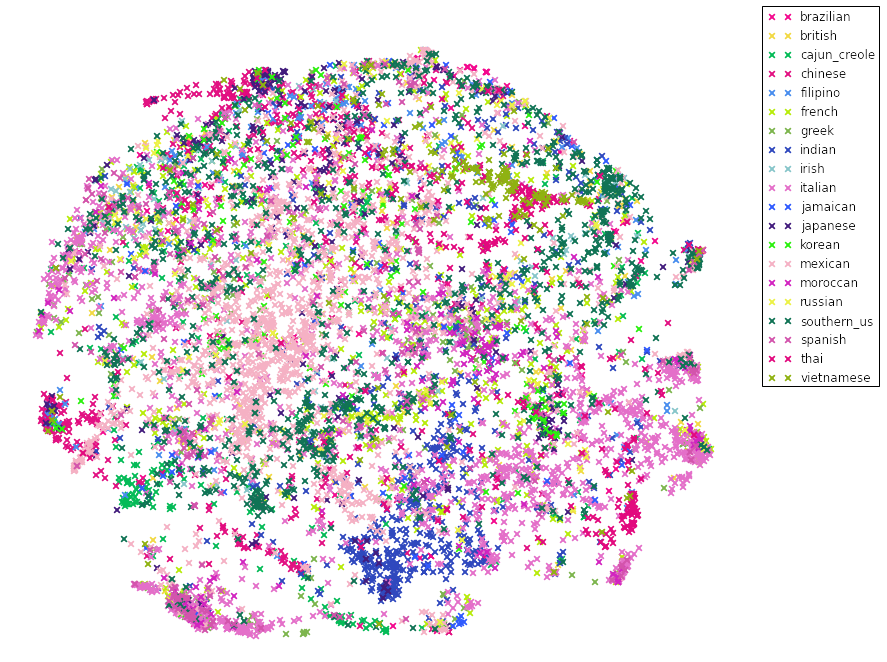

In [136]:
fig = figure(figsize=(10, 10))
ax = axes(frameon=False)
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,wspace=0.0, hspace=0.0)
for cuisine, group in grouped:
    color = np.random.rand(3,)
    ax.plot(group['x'], group['y'], marker='x', linestyle='',label=cuisine,color = color,mew=2)
    

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(())
plt.yticks(())



From the training data, we can see that maybe a linear decision boundary is not appropriate to categorize the cuisines based on their recipes.

#On Trial to Incorporate External Knowledge and Some Random Obvervations

The problem domain of recipe categorization contains abundant real life knowledge that can be outside from the provided taining set.  Judged by the top 'global' performance, (currently 83.9% at https://www.kaggle.com/c/whats-cooking/leaderboard, 5 days before closing), there is obviously a limit on how mainstream methodologies can be applied to this particular problem set.  Perhaps the original universe data set is too small to cover enough samples?  Perhaps the training data set is relatively too small to the univers or the selection is too 'biased'.  (We think the size and 'randomness' of the test set is normal, RELATIVELY to the training data set though).  Under the assumption and realization that these limitations are inhereted to this particular training data (either on the size or sampling method), we wanted to explore if there is anything external that can help (for the contest's sake and in gneral).

There are two levels of external knowledge that might be related to tackle this problem.  First one is from the individual ingredients to the classification.  The other level is the classifications of this problem, the 20 identified cuisine categories, form a natural cluster on its own.  (Like we know already French and Italian cusines are 'closer' to each other than say Chinese and Korean and the former can be grouped to European and the later can be grouped into Asian, etc.)  In many ways, we should already know ahead of time that any classification system will have 'confusion' problems, based on the external knowledge).

A few 'out-side-the-box' approaches is contemplated below, following some general examine on the dataset stats.

####note: to keep the existing code base 'uncontaiminated', the following code cells, starts an independent environment on its own and assumes NO history from all above

####Also, most of the code listed focuses on analyzing the train and test data themselves to offer possible approaches rather than  

First a few things to notice about the training and test data

In [5]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
import json
import random
import sklearn.ensemble
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import *
import pprint

In [7]:
#read in two json files

with open("train.json") as data_file:
    raw_train_data = json.loads(data_file.read())

with open("test.json") as test_file:
    raw_test_data = json.loads(test_file.read())
    
#check the dimensions, (each is a dictionary)

#raw_train_data, its length and first 1 elements

def peek(a, name='object', num=1): #print the length of a and pretty print its first n items
    print name+"' length:", len(a)
    pprint.pprint(a[0:num])
    print

peek(raw_train_data, "raw_train_data");
peek(raw_test_data, "raw_test_data");

raw_train_data' length: 39774
[{u'cuisine': u'greek',
  u'id': 10259,
  u'ingredients': [u'romaine lettuce',
                   u'black olives',
                   u'grape tomatoes',
                   u'garlic',
                   u'pepper',
                   u'purple onion',
                   u'seasoning',
                   u'garbanzo beans',
                   u'feta cheese crumbles']}]

raw_test_data' length: 9944
[{u'id': 18009,
  u'ingredients': [u'baking powder',
                   u'eggs',
                   u'all-purpose flour',
                   u'raisins',
                   u'milk',
                   u'white sugar']}]



In [15]:
#randomize
random.shuffle(raw_train_data)
train_data = [' '.join(d1.replace(" ","") for d1 in d["ingredients"]) for d in raw_train_data]
train_labels = [d['cuisine'] for d in raw_train_data]
train_ids = [d["id"] for d in raw_train_data]

#Here we are stipping the blanks so that each of the whole ingredients can be treated as one word
dev_train_data = [' '.join(d1.replace(" ","") for d1 in d["ingredients"]) for d in raw_train_data[len(raw_train_data)/3:]]
dev_train_labels = [d['cuisine'] for d in raw_train_data[len(raw_train_data)/3:]]
dev_test_data =  [' '.join(d1.replace(" ","") for d1 in d["ingredients"]) for d in raw_train_data[:len(raw_train_data)/3]]
dev_test_labels =  [d['cuisine'] for d in raw_train_data[:len(raw_train_data)/3]]
test_data = [' '.join(d1.replace(" ","") for d1 in d["ingredients"]) for d in raw_test_data]
test_ids = [d["id"] for d in raw_test_data]

peek(train_data, 'train_data')
peek(train_labels, 'train_labels')
peek(dev_train_data, 'dev_train_data')
peek(dev_train_labels, 'dev_train_labels')
peek(dev_test_data, 'dev_test_data')
peek(dev_test_labels, 'dev_test_labels')
peek(test_data, 'test_data')
peek(test_ids, 'test_ids')

train_data' length: 39774
[u'chickenstock blackbeans flourtortillas chilipowder garliccloves sugar oliveoil flour purpleonion oregano groundcloves garlicpowder cookedchicken salt groundcumin cheddarcheese limejuice jalapenochilies cinnamon choppedcilantrofresh']

train_labels' length: 39774
[u'mexican']

dev_train_data' length: 26516
[u'potatoes salt tarragonvinegar greenonions beefconsomme freshparsley groundblackpepper vegetableoil']

dev_train_labels' length: 26516
[u'french']

dev_test_data' length: 13258
[u'chickenstock blackbeans flourtortillas chilipowder garliccloves sugar oliveoil flour purpleonion oregano groundcloves garlicpowder cookedchicken salt groundcumin cheddarcheese limejuice jalapenochilies cinnamon choppedcilantrofresh']

dev_test_labels' length: 13258
[u'mexican']

test_data' length: 9944
[u'bakingpowder eggs all-purposeflour raisins milk whitesugar']

test_ids' length: 9944
[18009]



In [16]:
#a peek on the labels
cuisines = sorted(set(dev_train_labels).union(set(dev_test_labels)))
print len(cuisines), cuisines

20 [u'brazilian', u'british', u'cajun_creole', u'chinese', u'filipino', u'french', u'greek', u'indian', u'irish', u'italian', u'jamaican', u'japanese', u'korean', u'mexican', u'moroccan', u'russian', u'southern_us', u'spanish', u'thai', u'vietnamese']


In [17]:
#a quick rundown to see the training set broken down by cusines
X = {}
for c in cuisines:
    cat = []
    for i, g in enumerate(train_data):
        if train_labels[i]==c:
            cat.append(g)
    X[c] = cat
total = 0
for c in cuisines:
    print "For %s:" % (c)
    peek(X[c])
    total += len(X[c])
print total, len(train_labels)

For brazilian:
object' length: 467
[u'garlicpowder smokedpork blackbeans bacon driedoregano chickenbroth bayleaves basmatirice oliveoil salt']

For british:
object' length: 804
[u'sugar wholemilk salt rhubarb largeeggwhites heavycream vanillacustard unsaltedshelledpistachio largeeggyolks vanillaextract finosherry syrup almondextract all-purposeflour']

For cajun_creole:
object' length: 1546
[u'cookedrice LouisianaHotSauce flour cajunseasoning salt anchochilepepper dicedonions andouillesausage oliveoil redwinevinegar garlic dicedcelery greenbellpepper lime vegetableoil dicedtomatoes beer redchilipowder pepper groundsirloin guajillo beefbroth cumin']

For chinese:
object' length: 2673
[u'darksoysauce groundnut springonions pakchoi beansprouts sugar Shaoxingwine ginger carrots fishsauce water sesameoil garliccloves whitepepper mushrooms salt cornflour']

For filipino:
object' length: 755
[u'bakingpowder cakeflour sweetenedcondensedmilk warmwater yellowfoodcoloring softenedbutter creamofta

In [29]:
#the main purpose here is to get an idea how many different ingredients, when viewed as single word are involved in training and test dataset
#that is, 1-gram vocabulary = ingredient set
vec = TfidfVectorizer()
vec = TfidfVectorizer(ngram_range=(1,1))
some_vec = vec.fit_transform(train_data)
train_set = set(vec.vocabulary_.keys())
some_vec = vec.fit_transform(test_data)
test_set = set(vec.vocabulary_.keys())

in_train_but_not_in_test_set = train_set.difference(test_set)
in_test_but_not_in_train_set = test_set.difference(train_set)
in_both_set = train_set.intersection(test_set)
print len(train_set), len(test_set), len(in_train_but_not_in_test_set), len(in_test_but_not_in_train_set), len(in_both_set)
print list(in_both_set)[0:40]

6782 4544 2664 426 4118
[u'processcheesespread', u'toastedcoconut', u'mackerel', u'frozenspinach', u'pearlbarley', u'wholepeeledtomatoes', u'asian', u'bucatini', u'blacktruffles', u'cashewnuts', u'eyeroast', u'fishfillets', u'chickencutlets', u'orangeglaze', u'wholewheatpennepasta', u'pancetta', u'crushedtomatoes', u'leangroundpork', u'backbaconrashers', u'brownbasmatirice', u'barley', u'arbolchile', u'freshmexicancheese', u'babycarrots', u'boilingpotatoes', u'sliveredalmonds', u'faticcream', u'groundchickenbreast', u'sesameseeds', u'nonfatbuttermilk', u'kaffirlime', u'gremolata', u'biscuitdough', u'oilcuredolives', u'coffeeliqueur', u'figs', u'corngrits', u'cocktailcherries', u'skimmozzarellacheese', u'amaretticookies']


####From this 'difference' list, we found there are 426 one-word ingredients that are in the test set but not the training set, which increased the 'difficultness' of our problem.  For example, ingredients like 'bucatini', 'markerel', 'asian', 'cashewnuts' etc may possesse imporatant classification, but we have no chance to train our system.  One solution is to look for external knowledge for help.  **Provided that we can extract classification related info from the wording of the ingredients** directly.

####Below is a trial to link to English on line dictionary at WordNik.com

```
from wordnik import *
apiUrl = 'http://api.wordnik.com/v4'
apiKey = '6998b09da14f06ef0500f01667a06e16f49b2d9a0182ab620'
client = swagger.ApiClient(apiKey, apiUrl)
wordApi = WordApi.WordApi(client)
example = wordApi.getTopExample('irony')
defi = wordApi.getDefinitions('bok choy')
print defi[0].text

wordlist = set([])
dictionary = {}
for rec in dev_train_data:
    ing = rec.split()
    for w in ing:
        defi = wordApi.getDefinitions(w, limit=1)
        if(defi is not None):
            #for i in defi:
            words = defi[0].text.lower().replace('(','').replace(')','').split()
            found = set(words).intersection(set(dev_test_label))
            if(len(found)<>0 and w not in wordlist):
                wordlist = wordlist.union(w)
                dictionary[w] = found
```
######From which we learned the following list 

```
d = {u'banger': 'british', u'channa': 'indian', u'keema': u'indian', u'milkfish': 'indian', u'limoncello': 'italian', u'mortadella': 'italian', u'burrata': 'italian', u'parmesan': 'italian', u'mascarpone': 'italian', u'Texas': u'spanish', u'liquorice': 'british', u'chaat': 'indian', u'taleggio': 'italian', u'peanut': u'brazilian', u'yu': 'chinese', u'sashimi': 'japanese', u'pancetta': 'italian', u'cannellini': 'italian', u'focaccia': 'italian', u'ghee': 'indian', u'ricotta': 'italian', u'teriyaki': 'japanese', u'eau-de-vie': u'french', u'endive': u'indian', u'chapatti': 'indian', u'spumante': u'italian', u'wasabi': 'japanese', u'caciocavallo': 'italian', u'Wolf': u'spanish', u'umeboshi': 'japanese', u'jicama': u'mexican', u'ramen': 'japanese', u'ouzo': 'greek', u'mantou': 'chinese', u'earl': 'british', u'mirin': 'japanese', u'pecorino': 'italian', u'prosciutto': 'italian', u'robiola': 'italian', u'paella': 'spanish', u'Parmesan': 'italian', u'pizza': u'italian', u'shiso': 'japanese', u'Superior': u'french', u'Guinness': u'british', u'hoisin': 'chinese', u'lapsang': 'chinese', u'farofa': 'brazilian', u'tonkatsu': u'japanese', u'kimchi': u'korean', u'empanada': 'spanish', u'ume': 'japanese', u'brie': u'french', u'Key': u'british', u'calvados': 'french', u'mandarin': 'chinese', u'Galliano': u'italian', u'tempura': 'japanese', u'kefalotyri': 'greek', u'cornmeal': 'indian', u'broccolini': 'chinese', u'Arthur': u'british', u'Jamaican': 'jamaican', u'Curry': u'irish', u'mozzarella': 'italian', u'Goya': 'spanish', u'asiago': 'italian', u'Evans': u'british', u'nopales': 'mexican', u'eggplant': 'indian', u'chana': 'indian', u'Blanc': u'french', u'morcilla': 'spanish', u'besan': 'indian', u'mochi': 'japanese', u'Jameson': 'irish', u'Cayenne': u'french', u'raita': 'indian', u'matcha': 'japanese', u'Basil': u'greek', u'Victoria': u'british', u'Creole': 'spanish', u'beetroot': 'british', u'provolone': 'italian', u'shiitake': u'chinese', u'natto': 'japanese', u'ciabatta': 'italian', u'California': u'spanish', u'napa': 'chinese', u'masala': u'indian', u'Cara': 'irish', u'panko': 'japanese', u'tikka': 'indian', u'Chile': u'indian', u'kabocha': 'japanese', u'Argo': 'greek', u'paneer': 'indian', u'Reblochon': 'french', u'eau': 'french', u'gherkin': u'indian', u'Monterey': u'spanish', u'panettone': 'italian', u'kappa': 'greek', u'soba': 'japanese', u'peperoncini': 'greek', u'mochiko': 'japanese', u'cachaca': 'brazilian', u'ragu': 'italian', u'crackers': 'british', u'Jose': u'spanish', u'bhaji': 'indian', u'furikake': 'japanese', u'neem': u'indian', u'paratha': 'indian', u'pandan': 'indian', u'Cajun': 'french', u'amaretto': 'italian', u'peach': 'chinese', u'Baileys': 'irish', u'inch': u'british', u'sherry': 'spanish', u'Knox': u'british', u'guanciale': 'italian', u'phyllo': u'greek', u'tamale': 'mexican', u'pho': 'vietnamese', u'cardamom': 'indian', u'pastis': u'french', u'Grey': u'british', u'Heath': u'british', u'gorgonzola': 'italian', u'graviera': 'greek', u'wonton': 'chinese', u'bluefish': 'indian', u'gelato': 'italian', u'Sweet': u'british', u'daikon': u'japanese', u'carnitas': 'mexican', u'udon': 'japanese', u'methi': 'indian', u'manouri': 'greek', u'grappa': 'italian', u'komatsuna': 'japanese'}

print len(d)
143

```

#####We have not had a chance to integrate this external info into our system, but this external information, and perhaps along with some 'cuisine map' acquired from Cusine knowledgebase can both help enrich the feature for the learning system, when fully explored.